In [5]:
from langgraph.graph import START, END, StateGraph
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict, Literal

In [3]:
load_dotenv()

True

In [4]:
model = ChatGroq(model="openai/gpt-oss-20b")

In [8]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of User Review')

In [9]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [10]:
sentiment_struct_model = model.with_structured_output(SentimentSchema)
diagnosis_struct_model = model.with_structured_output(DiagnosisSchema)

In [ ]:
prompt = 'What is the sentiment of the following review - I ducking hate the software due to the bugs it have and its laggy nature'
sentiment_struct_model.invoke(prompt)

SentimentSchema(sentiment='negative')

In [14]:
class ReviewState(TypedDict):
    sentiment: Literal["positive", "negative"]
    review: str
    diagnosis: dict
    response: str

In [16]:
def find_sentiment(state: ReviewState):
    curr_review = state['review']
    prompt = f'What is the sentiment of the following review - {curr_review}'
    sentiment = sentiment_struct_model.invoke(prompt)
    
    return {'sentiment': sentiment}

In [25]:
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diag"]:
    return 'positive_response' if state['sentiment'] == 'positive' else 'run_diag'

In [26]:
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).conten
    return {'response' : response}

In [27]:
def run_diag(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency."""
    
    response = diagnosis_struct_model.invoke(prompt)
    return {'diagnosis': response.model_dump()}

In [28]:
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content
    return {'response': response}

In [29]:
# Define graph
graph = StateGraph(ReviewState)

# Add Nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('run_diag', run_diag)
graph.add_node('negative_response', negative_response)
graph.add_node('positive_response',positive_response)

# Add Edges
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('run_diag', 'negative_response')
graph.add_edge('positive_response', END)
graph.add_edge('negative_response', END)

In [30]:
# COmpile the graph
workflow = graph.compile()

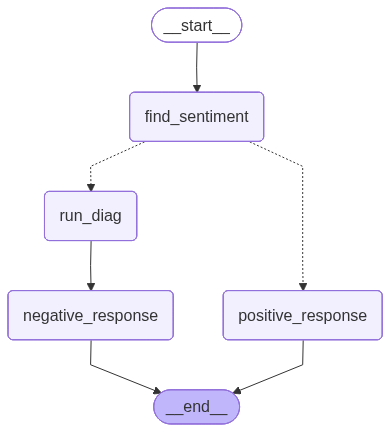

In [31]:
workflow

In [35]:
initial_state = {'review' : 'I ducking hate the software due to the bugs it have and its laggy nature'}
workflow.invoke(initial_state)

{'sentiment': SentimentSchema(sentiment='negative'),
 'review': 'I ducking hate the software due to the bugs it have and its laggy nature',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': 'Hi there,\n\nI’m really sorry to hear you’re running into this bug – I can understand how frustrating it must be, especially when it’s happening right now. I’m here to help get this sorted out for you as quickly as possible.\n\n**What we’re going to do next**\n\n1. **Confirm the issue** – Could you let me know the exact error message you’re seeing, the steps that lead to it, and whether it happens on all devices or just one? If you have a screenshot or a short screen recording, that would be incredibly helpful.\n\n2. **Quick work‑arounds** – While we dig into the root cause, here are a couple of things you can try right away:\n   - **Clear your browser cache** (or try a different browser) – sometimes stale data can trigger odd errors.\n   - **Restart the app** (o